In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy


# required only for jupyter notebooks / while running on colab
%matplotlib inline 

# set seed
seed = 1
np.random.seed(seed)

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [ ]:
batch_size = 64
IMG_SIZE = 224
img_height = 224
img_width = 224
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
  'Data/train',
   labels='inferred',
    label_mode='categorical', 
  image_size=(img_height, img_width),
  batch_size=batch_size)

ds_test = tf.keras.preprocessing.image_dataset_from_directory(
  'Data/test',
   labels='inferred',
    label_mode='categorical', 
  image_size=(img_height, img_width),
  batch_size=batch_size)
NUM_CLASSES = 120

In [10]:
def fitness(alpha, beta, gamma, ds_train):
    model = EfficientNetB0(alpha, beta, gamma, weights='imagenet')

In [11]:
#GRADED - 0.75 MARKS
# Defining a particle
class Particle():
    ''' A single partice, part of a swarm for PSO '''
    
    def __init__(self, x, y, vx, vy): # Task 1
        ''' initialize the particle'''
        # YOUR CODE HERE
        self.pos = np.array([x,y])
        self.vel = np.array([vx,vy])
        self.best_pos = self.pos
        #raise NotImplementedError()
    
    def __str__(self):
        ''' Controls how a particle is printed '''
        return f'Particle: pos: {self.pos}, velocity: {self.vel} fitness: {fitness(self.pos)}'
    
    def __repr__(self):
        ''' Controls how a particle is printed as a part of a list'''
        return f'Particle: pos: {self.pos}, velocity: {self.vel} fitness: {fitness(self.pos)}'        

In [12]:
#GRADED - 0.75 MARKS
def initialize_swarm(hyper_params): # task 2
    '''
    Initialize a swarm of particles using the Particle class
    '''
    particles = []
    p_lo, p_hi = hyper_params['pos_range']
    v_lo, v_hi = hyper_params['vel_range']

    for i in range(hyper_params['pop_size']):

        # Create a particle with random position and random velocity and add it to the particles array
        # YOUR CODE HERE
        x = np.random.random()*(p_hi-p_lo)-np.abs(p_lo)
        y = np.random.random()*(p_hi-p_lo)-np.abs(p_lo)
        vx = np.random.random()*(v_hi-v_lo)-np.abs(v_lo)
        vy = np.random.random()*(v_hi-v_lo)-np.abs(v_lo)
        particles.append(Particle(x,y,vx,vy))
        #raise NotImplementedError()
        
    best_particle = max(particles, key = lambda p: fitness(p.pos)) # Understand what this line does properly, you will need to use something similar later on
    best_pos = best_particle.pos

    return {
        'best_pos': best_pos,
        'population': particles,
    }

In [13]:
#GRADED - 0.75 MARKS
def update_velocity(hyper_params, swarm, particle ): # task 3  
    '''
    Update the given particle's velocity
    '''
    w, c1, c2 = hyper_params['w'], hyper_params['c1'], hyper_params['c2']
    # YOUR CODE HERE
    particle.vel = ((w*particle.vel) +(c1*np.random.rand()*(particle.best_pos - particle.pos))+(c2*np.random.rand()*(swarm['best_pos'] - particle.pos)))/(w+c1+c2)
    #raise NotImplementedError()

In [14]:
#GRADED - 0.75 MARKS
def update_position(hyper_params, particle): # task 4
    '''
    Update the given particle's position
    '''
    
    # YOUR CODE HERE
    p_lo, p_hi = hyper_params['pos_range']
    particle.pos = particle.pos + particle.vel
    particle.pos = np.clip(particle.pos, p_lo, p_hi)
    if(fitness(particle.pos) > fitness(particle.best_pos)):
        particle.best_pos = particle.pos
    #raise NotImplementedError()

In [15]:
#GRADED - 2 MARKS
def PSO(hyper_params):
    '''
    Implementing Particle Swarm Optimization 
    '''
    history = []

    swarm = initialize_swarm(hyper_params)

    for i in range(hyper_params['iterations']):
        for j in range(hyper_params['pop_size']):
        # YOUR CODE HERE
            update_velocity(hyper_params,swarm,swarm['population'][j])
            update_position(hyper_params,swarm['population'][j])
        bestparticle = max(swarm['population'], key = lambda p: fitness(p.pos))
        if(fitness(bestparticle.pos) > fitness(swarm['best_pos'])):
            swarm['best_pos'] = bestparticle.pos
        history.append(deepcopy(swarm)) # Do not modify, this is used for visualization
    #raise NotImplementedError()
        
    
        
    return swarm['best_pos'], history

In [16]:
hyper_params = {
    'w': 10, # inertia 
    'c1': 0.1, # local
    'c2': 0.2, # global
    'pos_range': (-7,7), # range in which a PSO particle can move
    'vel_range': (-1,1), # velocity range for a PSO particle
    'pop_size': 5, # Number of particles in the swarm
    'iterations': 100, # Number of iterations
}

optimum, hist = PSO(hyper_params)
print(f'PSO found the optimum at {optimum} with a fitness of {fitness(optimum)}')
print('The global maxima is at [0 0] with a cost of 0')

PSO found the optimum at [-0.04425666 -0.03629094] with a fitness of -0.24722853633721487
The global maxima is at [0 0] with a cost of 0


100%|██████████| 100/100 [00:03<00:00, 25.93it/s]


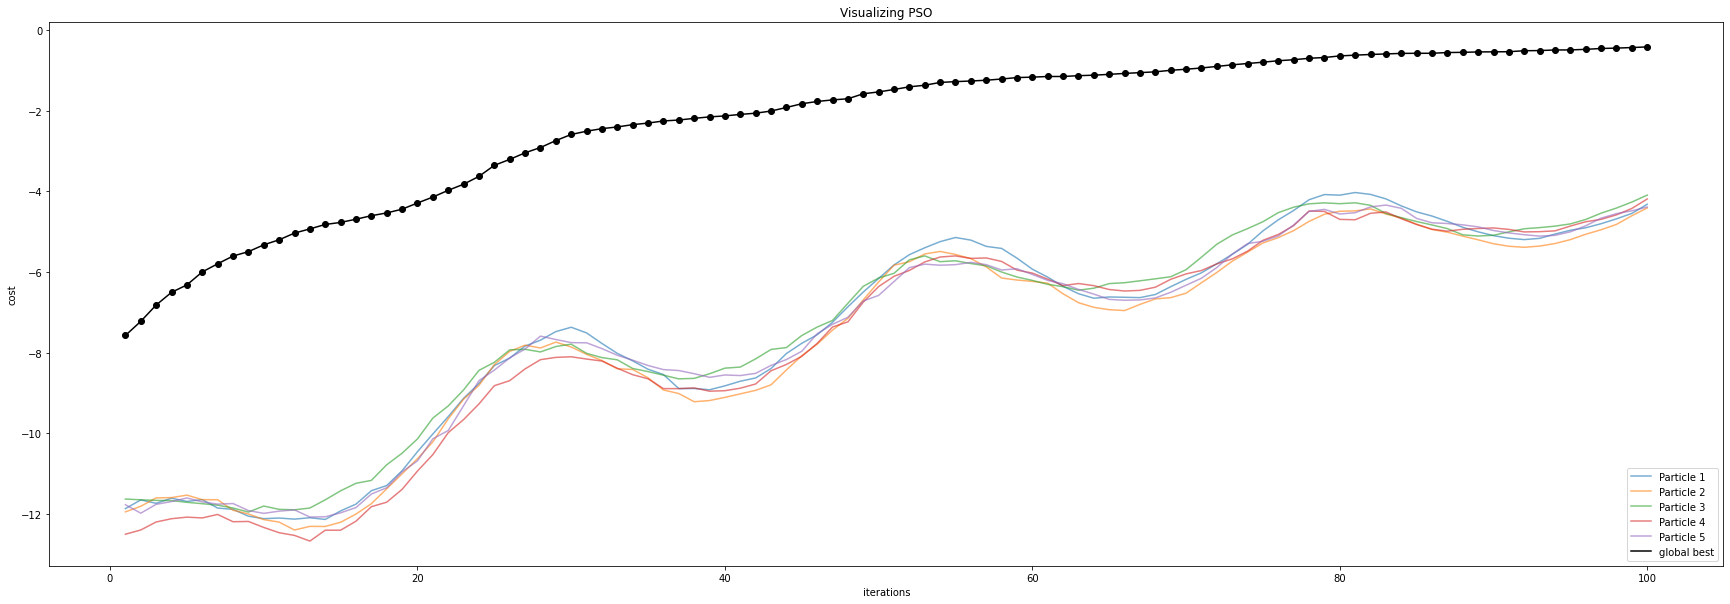

In [17]:
num_trials = 100 # Run the PSO algorithm 100 times and show the average results

hists = []
for _ in tqdm(range(num_trials)):
    _, hist = PSO(hyper_params)
    hists.append(hist)

global_best = [0]*hyper_params['iterations']
particle_best = [[0]*hyper_params['iterations'] for p in range(hyper_params['pop_size'])]

for hist in hists:
    for i,swarm in enumerate(hist):
        global_best[i] += fitness(swarm['best_pos']) / num_trials
        for j,particle in enumerate(swarm['population']):
            particle_best[j][i] += fitness(particle.pos)/ num_trials
    
plt.rcParams["figure.figsize"] = (30,10)

x = list(range(1, hyper_params['iterations']+1))
for i in range(hyper_params['pop_size']):
    plt.plot(x, particle_best[i], label=f'Particle {i+1}', alpha=0.6)

plt.plot(x, global_best, label='global best', c='k')
plt.scatter(x, global_best, marker='o', c='k')

plt.title('Visualizing PSO')
plt.xlabel('iterations')
plt.ylabel('cost')
plt.legend(loc='lower right')
plt.show()